In [37]:
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math


In [3]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out_6 = self.linear_3(out_5)
        return out_6

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 5, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 5, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 5, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 256)
        self.linear2 = nn.Linear(256, 512)
        self.linear3 = nn.Linear(512, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.view(conv3.shape[0], -1)
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out = self.linear3(out_2)
        return out

In [6]:
class Trainer():
    def __init__(self, generator, discriminator, optim_g, optim_d, lambda_weight, critic_iterations, device):
        self.generator = generator
        self.discriminator = discriminator
        self.optim_g = optim_g
        self.optim_d = optim_d
        self.lambda_weight = lambda_weight
        self.critic_iterations = critic_iterations
        self.losses = {"d": [], "g": [], "gp": [], "gradient_norm": []}
        self.num_steps = 0
        self.generator = self.generator.to(device)
        self.discriminator = self.discriminator.to(device)
    
    def critic_train_step(self, x, y, lookback, output_dim, device):
        fake_data = self.generator(x)
        fake_data = torch.cat([y[:, :lookback, :], fake_data.reshape(-1, 1, output_dim)], axis=1)

        critic_real = self.discriminator(y)
        critic_fake = self.discriminator(fake_data)

        gp = self.gradient_penalty(y, fake_data, device)
        self.losses['gp'].append(gp.item())

        self.optim_d.zero_grad()
        d_loss = critic_fake.mean() - critic_real.mean() + gp
        d_loss.backward()

        self.optim_d.step()

        self.losses['d'].append(d_loss.item())
    
    def generator_train_step(self, x, y, lookback, output_dim):
        fake_data = self.generator(x)
        fake_data = torch.cat([y[:, :lookback, :], fake_data.reshape(-1, 1, output_dim)], axis=1)

        critic_fake = self.discriminator(fake_data)

        self.optim_g.zero_grad()
        g_loss = -critic_fake.mean()
        g_loss.backward()

        self.optim_g.step()

        self.losses['g'].append(g_loss.item())
    
    def gradient_penalty(self, real_data, fake_data, device):
        batch_size = real_data.size(0)
        alpha = torch.rand(batch_size, 1, 1).to(device)

        interpolated = (alpha * real_data.data + (1 - alpha) * fake_data.data.requires_grad_(True)).to(device)

        prob_interpolated = self.discriminator(interpolated)

        gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                                        grad_outputs=torch.ones(prob_interpolated.size()).to(device),
                                        create_graph=True, retain_graph=True)[0]

        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().item())

        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        return self.lambda_weight * ((gradients_norm - 1) ** 2).mean()
    
    def train(self, data_loader, epochs, lookback, output_dim, device):
        for epoch in range(epochs):
            for x, y in data_loader:
                x, y = x.to(device), y.to(device)
                
                for _ in range(self.critic_iterations):
                    self.critic_train_step(x, y, lookback, output_dim, device)
                
                self.generator_train_step(x, y, lookback, output_dim)
                
                self.num_steps += 1
                
            print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {self.losses['d'][-1]:.4f} | G Loss: {self.losses['g'][-1]:.4f} | GP: {self.losses['gp'][-1]:.4f} | Grad Norm: {self.losses['gradient_norm'][-1]:.4f}")
    

In [ ]:
import numpy as np
import torch
import re
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

def sliding_window(x: np.array, y: np.array, window: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    x_ = []
    y_ = []
    y_gan = []

    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)

    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()

    return x_, y_, y_gan

def build_windows_per_ticker(x: np.array, y: np.array, window: int, tickers: np.array) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    x_, y_, y_gan_ = [], [], []

    df_x, df_y = pd.DataFrame(x), pd.DataFrame(y)
    df_ticker = pd.Series(tickers)
    for _, index_mask in df_ticker.groupby(df_ticker).groups.items():
        x_ticker = df_x.iloc[index_mask].values
        y_ticker = df_y.iloc[index_mask].values

        if len(x_ticker) > window:
            x_w, y_w, y_gan_w = sliding_window(x_ticker, y_ticker, window)
            x_.append(x_w)
            y_.append(y_w)
            y_gan_.append(y_gan_w)

    x_ = torch.cat(x_, dim=0)
    y_ = torch.cat(y_, dim=0)
    y_gan_ = torch.cat(y_gan_, dim=0)

    return x_, y_, y_gan_


def remove_unicode(text):
    return re.sub(r'[^\x00-\x7F]+', '', text)


def date_encoding(date) -> dict:
    #ts = datetime.strptime(date, "%Y%m%dT%H%M%S")
    # year = ts.year
    month = date.month
    day = date.day
    hour = date.hour
    minute = date.minute
    #second = date.second
    # might add day of the week via one hot encoding

    hours_cos, hours_sin = cyclical_encoding(hour, 24)
    minutes_cos, minutes_sin = cyclical_encoding(minute, 60)
    month_cos, month_sin = cyclical_encoding(month, 12)
    day_cos, day_sin = cyclical_encoding(day, 31)

    date_data = {"month_cos": month_cos, 
                "month_sin": month_sin, 
                "day_cos": day_cos, 
                "day_sin": day_sin, 
                "hours_cos": hours_cos, 
                "hours_sin": hours_sin, 
                "minutes_cos": minutes_cos, 
                "minutes_sin": minutes_sin, 
                }

    # consider adding minmaxscaler to time data

    return date_data


def cyclical_encoding(time, max_days: int) -> list[int]:
    radians = 2 * np.pi * time / max_days
    return np.cos(radians), np.sin(radians)


def one_hot_encoding(train_df, test_df):
    one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    one_hot_encoder.fit(train_df[["ticker"]])
    train_encoded = one_hot_encoder.transform(train_df[["ticker"]])
    test_encoded = one_hot_encoder.transform(test_df[["ticker"]])

    return train_encoded, test_encoded
    # encoding = {}
    # for cat in categories:
    #     if cat == category:
    #         encoding[cat] = 1
    #     else:
    #         encoding[cat] = 0
    # return encoding

In [28]:
csv_path = 'data/pltr_aapl_msft.csv'

df = pd.read_csv(csv_path)
df = df.dropna()

df['date'] = pd.to_datetime(df['date'])

year = df['date'].dt.year - 1
month = df['date'].dt.month - 1
day = df['date'].dt.day - 1

period = 10 # however long the data goes back
df["year_cos"], df["year_sin"] = cyclical_encoding(year, period)
df["month_cos"], df["month_sin"] = cyclical_encoding(month, 12)
df["day_cos"], df["day_sin"] = cyclical_encoding(day, 31)

df["y"] = df["Close"]

split_idx = int(df.shape[0] * 0.8)
train_df, test_df = df[:split_idx], df[split_idx:]

train_ticker_encoded, test_ticker_encoded = one_hot_encoding(train_df, test_df)

feature_cols = [c for c in df.columns if c not in ["date", "y", "Close", "ticker"]]
x_train = train_df[feature_cols].values
x_test = test_df[feature_cols].values

x_train = np.concatenate([x_train, train_ticker_encoded], axis=1)
x_test = np.concatenate([x_test, test_ticker_encoded], axis=1)

y_train = train_df[["y"]].values
y_test = test_df[["y"]].values

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_train shape: {y_test.shape}")

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.transform(x_test)

y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

print(f"After scaling: x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
# print(f"x_train columns: {feature_cols + list(range(train_ticker_encoded.shape[1]))}")

lookback = 3
x_train_slide, y_train_scalar, y_train_slide = build_windows_per_ticker(x_train, y_train, lookback, train_df['ticker'].values)
x_test_slide, y_test_scalar, y_test_slide = build_windows_per_ticker(x_test, y_test, lookback, test_df['ticker'].values)

print(f"After sliding window: x_train shape: {x_train_slide.shape}, y_train shape: {y_train_scalar.shape}, y_train_gan shape: {y_train_slide.shape}")
print(f"After sliding window: x_test shape: {x_test_slide.shape}, y_test shape: {y_test_scalar.shape}, y_test_gan shape: {y_test_slide.shape}")

batch_size = 128
train_loader = DataLoader(
    TensorDataset(x_train_slide, y_train_slide),
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    TensorDataset(x_test_slide, y_test_slide),
    batch_size=batch_size,
    shuffle=False
)

for x_batch, y_batch in train_loader:
    print(f'Batch x train: {x_batch.shape}, Batch y train: {y_batch.shape}')
    break

for x_batch, y_batch in test_loader:
    print(f'Batch x test: {x_batch.shape}, Batch y test: {y_batch.shape}')
    break

x_train shape: (4931, 54), y_train shape: (4931, 1)
x_test shape: (1233, 54), y_train shape: (1233, 1)
After scaling: x_train shape: (4931, 54), y_train shape: (4931, 1)
After sliding window: x_train shape: torch.Size([4922, 3, 54]), y_train shape: torch.Size([4922, 1]), y_train_gan shape: torch.Size([4922, 4, 1])
After sliding window: x_test shape: torch.Size([1230, 3, 54]), y_test shape: torch.Size([1230, 1]), y_test_gan shape: torch.Size([1230, 4, 1])
Batch x train: torch.Size([128, 3, 54]), Batch y train: torch.Size([128, 4, 1])
Batch x test: torch.Size([128, 3, 54]), Batch y test: torch.Size([128, 4, 1])


In [29]:
learning_rate = 1e-4
num_epochs = 100
critic_iterations = 5
n_features = x_train.shape[1]
output_dim = y_train.shape[1]
print(f"Number of features: {n_features}, Output dimension: {output_dim}")
betas = [0.5, 0.9]
lambda_weight = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(n_features).to(device)
discriminator = Discriminator().to(device)

optim_g = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=betas)
optim_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=betas)

trainer = Trainer(generator, discriminator, optim_g, optim_d, lambda_weight=lambda_weight, critic_iterations=critic_iterations, device=device)

trainer.train(train_loader, epochs=num_epochs, lookback=lookback, output_dim=output_dim, device=device)

Number of features: 54, Output dimension: 1
Epoch [1/100] | D Loss: 6.5390 | G Loss: -5.2911 | GP: 1.9292 | Grad Norm: 0.5651
Epoch [2/100] | D Loss: -4.9321 | G Loss: 5.0422 | GP: 2.1862 | Grad Norm: 0.9380
Epoch [3/100] | D Loss: 0.3315 | G Loss: -1.8358 | GP: 0.0601 | Grad Norm: 0.9725
Epoch [4/100] | D Loss: 1.7904 | G Loss: -6.0742 | GP: 0.9764 | Grad Norm: 0.7061
Epoch [5/100] | D Loss: 1.0179 | G Loss: -6.4039 | GP: 0.5566 | Grad Norm: 0.8892
Epoch [6/100] | D Loss: 0.0236 | G Loss: -5.1621 | GP: 0.0146 | Grad Norm: 0.9917
Epoch [7/100] | D Loss: -0.0286 | G Loss: -4.8373 | GP: 0.0047 | Grad Norm: 1.0102
Epoch [8/100] | D Loss: -0.0044 | G Loss: -5.0806 | GP: 0.0049 | Grad Norm: 0.9930
Epoch [9/100] | D Loss: -0.0004 | G Loss: -5.1504 | GP: 0.0024 | Grad Norm: 1.0044
Epoch [10/100] | D Loss: -0.0004 | G Loss: -5.1875 | GP: 0.0016 | Grad Norm: 1.0025
Epoch [11/100] | D Loss: -0.0105 | G Loss: -5.1385 | GP: 0.0022 | Grad Norm: 0.9963
Epoch [12/100] | D Loss: 0.0009 | G Loss: -5.26

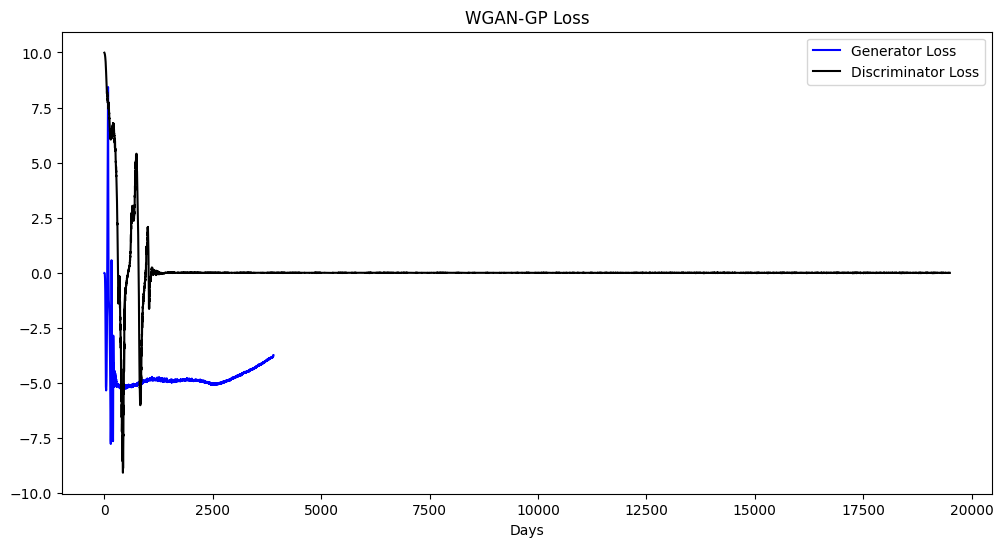

In [30]:
plt.figure(figsize = (12, 6))
plt.plot(trainer.losses['g'], color = 'blue', label = 'Generator Loss')
plt.plot(trainer.losses['d'], color = 'black', label = 'Discriminator Loss')
plt.title('WGAN-GP Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

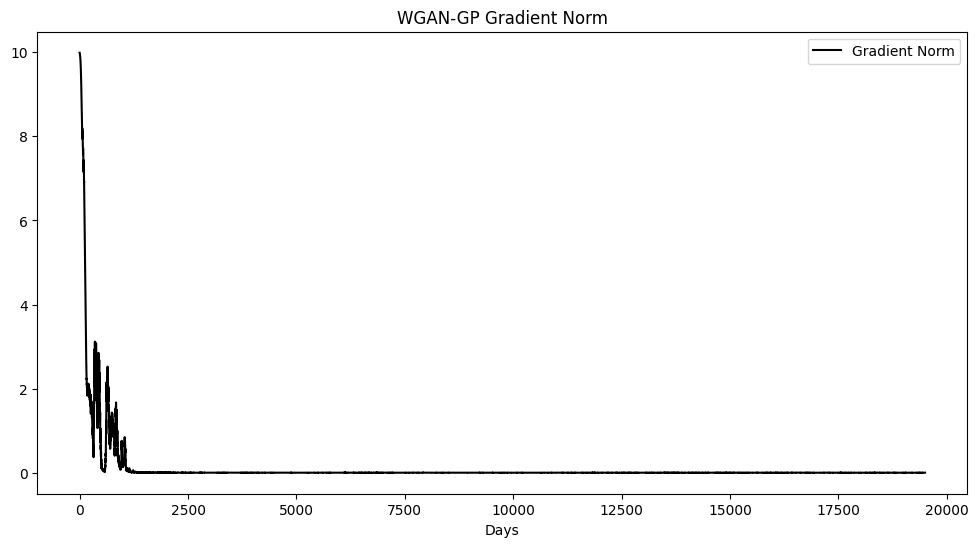

In [31]:
plt.figure(figsize = (12, 6))
plt.plot(trainer.losses['gp'], color = 'black', label = 'Gradient Norm')
plt.title('WGAN-GP Gradient Norm')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [35]:
generator.eval()
y_train_pred = generator(x_train_slide.to(device))
y_test_pred = generator(x_test_slide.to(device))

y_train_true = y_scaler.inverse_transform(y_train_scalar)
y_train_pred = y_scaler.inverse_transform(y_train_pred.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(y_test_scalar.reshape(-1, 1))
y_test_pred = y_scaler.inverse_transform(y_test_pred.cpu().detach().numpy())

Training dataset RMSE:3.5636584913093388
Training dataset MAE:2.306710036904444
Training dataset R2:0.9969872809732341


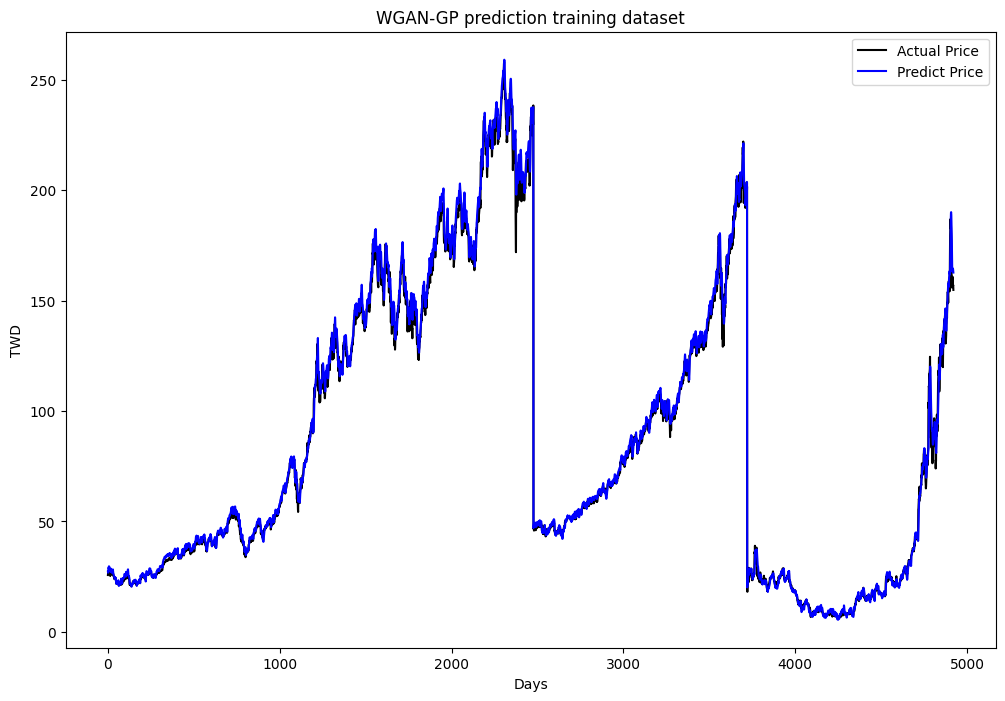

In [38]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Actual Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

mse = mean_squared_error(y_train_true, y_train_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_train_true, y_train_pred)
r2 = r2_score(y_train_true, y_train_pred)

print(f'Training dataset RMSE:{rmse}')
print(f'Training dataset MAE:{mae}')
print(f'Training dataset R2:{r2}')

In [26]:
print(y_test_true.shape, y_test_pred.shape)

(1487, 1) (1487, 1)


Training dataset RMSE:48.754342256635695
Training dataset MAE:2.306710036904444
Training dataset R2:0.9969872809732341


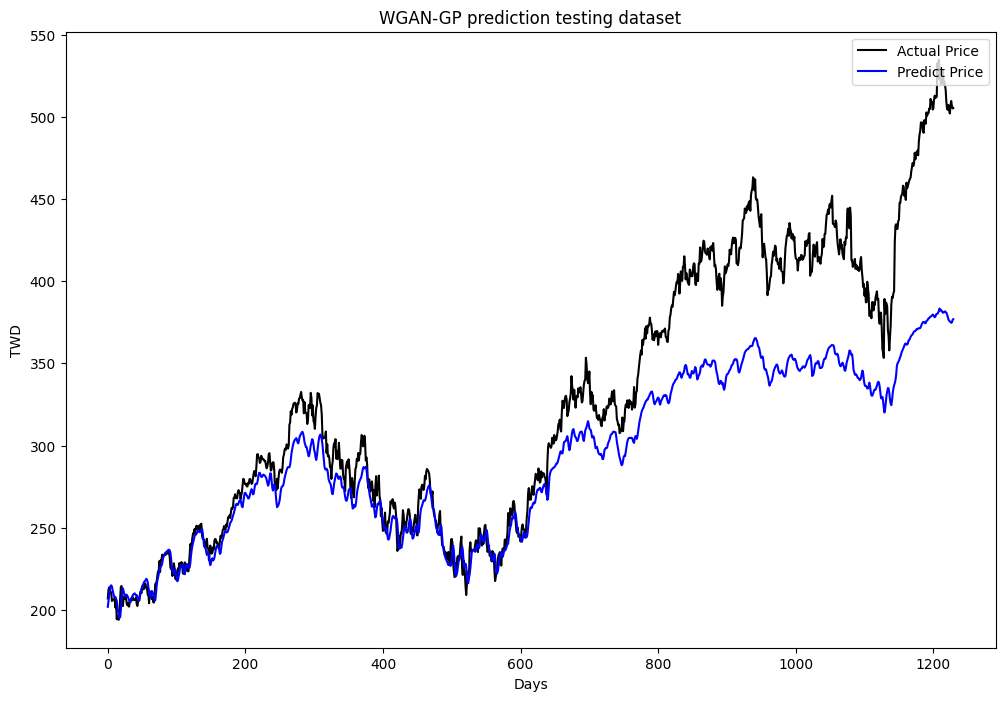

In [39]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Actual Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

mse = mean_squared_error(y_test_true, y_test_pred)
rmse = math.sqrt(mse)
print(f'Training dataset RMSE:{rmse}')
print(f'Training dataset MAE:{mae}')
print(f'Training dataset R2:{r2}')